## Análisis Directividad

In [2]:
import os
import sounddevice as sd
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa as li
from scipy import signal
import pandas as pd

In [2]:
sd.query_devices()

  0 Asignador de sonido Microsoft - Input, MME (2 in, 0 out)
> 1 Microphone (DroidCam Virtual Au, MME (1 in, 0 out)
  2 Asignador de sonido Microsoft - Output, MME (0 in, 2 out)
< 3 Speakers (High Definition Audio, MME (0 in, 2 out)
  4 1 - HDMI    (AMD High Definitio, MME (0 in, 2 out)
  5 Output (AMD HD Audio HDMI out #0), Windows WDM-KS (0 in, 2 out)
  6 MIDI (DroidCam Audio), Windows WDM-KS (1 in, 0 out)
  7 Output (DroidCam Audio), Windows WDM-KS (0 in, 1 out)
  8 Speakers (HD Audio Speaker), Windows WDM-KS (0 in, 2 out)

In [3]:
sd.default.device = 1
fs = 48000

### Importación de Archivos y Detección de Notas

Importamos todos los archivos de audio de la carpeta y los guardamos en una lista. Generamos una lista con todos los cortes para luego segmentar las notas.

A4_69_4hPa_Tapa Izquierda_Abriendo_Uhlig_Apuntado mic 1_Laboratorio LAPSo_2023-10-12_16-40.wav


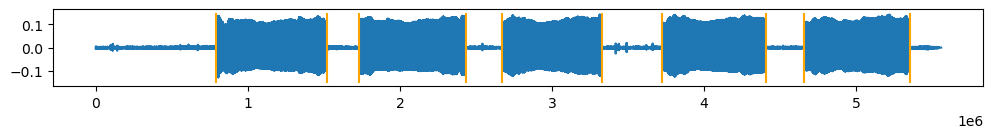

D4_62_4hPa_Tapa Derecha_Cerrando_Uhlig_Apuntado mic 3_Laboratorio LAPSo_2023-10-12_18-38.wav


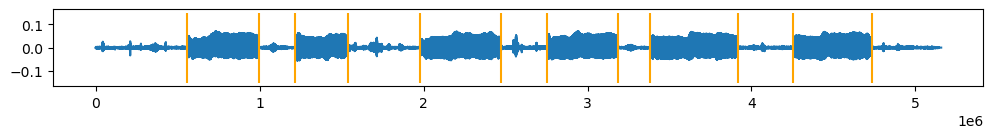

,Nota,Tapa,Accion,Midi,Fundamental,Presion_Aprox,Mic_Apuntado,Bandoneon,Recinto,Fecha,Sample_Rate,Muestra
0,A4,Izquierda,Abriendo,69,440.000000,4hPa,1,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[0.0052030087, 0.0053031445, 0.005182743, 0.0..."
1,A4,Izquierda,Abriendo,69,440.000000,4hPa,1,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[-0.0070706606, -0.006670356, -0.006087184, -..."
2,A4,Izquierda,Abriendo,69,440.000000,4hPa,1,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[2.4437904e-05, 0.0014997721, 0.00295043, 0.0..."
3,A4,Izquierda,Abriendo,69,440.000000,4hPa,1,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[-0.027008176, -0.025635242, -0.024558187, -0..."
4,A4,Izquierda,Abriendo,69,440.000000,4hPa,1,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[0.01936388, 0.020341873, 0.021387339, 0.0222..."
5,D4,Derecha,Cerrando,62,293.664768,4hPa,3,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[-0.0096360445, -0.008427978, -0.0071959496, ..."
6,D4,Derecha,Cerrando,62,293.664768,4hPa,3,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[0.011003137, 0.010695338, 0.010074139, 0.009..."
7,D4,Derecha,Cerrando,62,293.664768,4hPa,3,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[-0.003997326, -0.0041657686, -0.00489223, -0..."
8,D4,Derecha,Cerrando,62,293.664768,4hPa,3,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[-0.011891842, -0.010565877, -0.009298682, -0..."
9,D4,Derecha,Cerrando,62,293.664768,4hPa,3,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[0.010231614, 0.009287357, 0.008146524, 0.007..."


In [34]:
path = "Grabaciones Bandoneon/"
# Guardamos todos los nombres de archivo en una lista
files_list = os.listdir(path)

# Variables para los cortes
topdb = 12
framelength = 10
margen = 5000  # Margen para recortar los samples (en muestras)

# Dataframe para guardar los datos
df = pd.DataFrame(
    columns=[
        "Nota",
        "Tapa",
        "Accion",
        "Midi",
        "Fundamental",
        "Presion_Aprox",
        "Mic_Apuntado",
        "Bandoneon",
        "Recinto",
        "Fecha",
        "Sample_Rate",
        "Muestra",
    ]
)

for file in files_list:
    audio, sr = li.load(f"{path}{file}", mono=False, sr=fs)

    # Variables extraidas del nombre del archivo, para guardar en el Dataframe
    note_name = file.split("_")[0]
    midi_note = int(file.split("_")[1])
    presion_aprox = file.split("_")[2]
    tapa = file.split("_")[3].lstrip("Tapa ")
    accion = file.split("_")[4]
    bandoneon = file.split("_")[5]
    apuntado = int(file.split("_")[6].lstrip("Apuntado mic "))
    recinto = file.split("_")[7]
    fecha = file.split("_")[8]

    fundamental = li.midi_to_hz(midi_note)  # Convertimos midi a frecuencia

    # Filtramos solo el contenido armónico de la fundamental para hacer el análisis de las divisones con split.
    # Este código le pertenece a Juan Ramos.
    b, a = signal.butter(4, [fundamental * 0.9, fundamental / 0.3], "bandpass", fs=fs)
    filt = signal.filtfilt(b, a, audio[0])
    contenido_armonico = li.effects.harmonic(filt, margin=10)

    div = li.effects.split(
        contenido_armonico,
        top_db=topdb,
        frame_length=2048 * framelength,
        hop_length=2048,
    )  # Lista con los cortes

    for d in div:
        muestra = audio[:, d[0] + margen : d[1] - margen]  # Una sola nota

        # Guardamos los datos que van a ingresar en el dataframe y los metemos en una nueva fila
        new_row = {
            "Muestra": muestra,
            "Midi": midi_note,
            "Fundamental": fundamental,
            "Nota": note_name,
            "Presion_Aprox": presion_aprox,
            "Tapa": tapa,
            "Accion": accion,
            "Sample_Rate": sr,
            "Bandoneon": bandoneon,
            "Mic_Apuntado": apuntado,
            "Recinto": recinto,
            "Fecha": fecha,
        }
        df.loc[len(df)] = new_row

    # Graficar cada archivo de audio con sus cortes, comentar si no es necesario.
    print(file)
    plt.subplots(figsize=(12, 1))
    plt.plot(audio[0])
    plt.vlines(div, ymax=0.15, ymin=-0.15, colors="orange")
    plt.show()


# Convertir el dtype de la columna de fecha
df["Fecha"] = pd.to_datetime(df["Fecha"])

df

In [30]:
df

,Nota,Tapa,Accion,Midi,Fundamental,Presion_Aprox,Mic_Apuntado,Bandoneon,Recinto,Fecha,Sample_Rate,Muestra
0,A4,Izquierda,Abriendo,69,440.000000,4hPa,1,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[0.0052030087, 0.0053031445, 0.005182743, 0.0..."
1,A4,Izquierda,Abriendo,69,440.000000,4hPa,1,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[-0.0070706606, -0.006670356, -0.006087184, -..."
2,A4,Izquierda,Abriendo,69,440.000000,4hPa,1,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[2.4437904e-05, 0.0014997721, 0.00295043, 0.0..."
3,A4,Izquierda,Abriendo,69,440.000000,4hPa,1,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[-0.027008176, -0.025635242, -0.024558187, -0..."
4,A4,Izquierda,Abriendo,69,440.000000,4hPa,1,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[0.01936388, 0.020341873, 0.021387339, 0.0222..."
5,D4,Derecha,Cerrando,62,293.664768,4hPa,3,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[-0.0096360445, -0.008427978, -0.0071959496, ..."
6,D4,Derecha,Cerrando,62,293.664768,4hPa,3,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[0.011003137, 0.010695338, 0.010074139, 0.009..."
7,D4,Derecha,Cerrando,62,293.664768,4hPa,3,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[-0.003997326, -0.0041657686, -0.00489223, -0..."
8,D4,Derecha,Cerrando,62,293.664768,4hPa,3,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[-0.011891842, -0.010565877, -0.009298682, -0..."
9,D4,Derecha,Cerrando,62,293.664768,4hPa,3,Uhlig,Laboratorio LAPSo,2023-10-12,48000,"[[0.010231614, 0.009287357, 0.008146524, 0.007..."
